In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import factorial
from scipy import integrate

import scienceplots
plt.style.use(['science', 'notebook', 'grid'])

In [3]:
IP_eV = {
    'He': 24.587,   
    'Li': 5.392,    
    'Be': 9.323,    
    'B': 8.298,    
    'C': 11.260,   
    'N': 14.534,   
    'O': 13.618,   
    'F': 17.423,   
    'Ne': 21.564   
}
#source: https://en.wikipedia.org/wiki/Ionization_energies_of_the_elements_(data_page)

In [4]:
df = pd.read_csv('output2.csv')
df.head(20)

,Element,Z,Orbital,Exponent,C_1s,C_2s,C2_p
0,He,2,1S,1.4595,1.347900,0.000000,0.0
1,He,2,3S,5.3244,-0.001613,0.000000,0.0
2,He,2,2S,2.6298,-0.100506,0.000000,0.0
3,He,2,2S,1.7504,-0.270779,0.000000,0.0
4,Li,3,1S,4.3069,0.141279,-0.022416,0.0
5,Li,3,1S,2.4573,0.874231,-0.135791,0.0
6,Li,3,3S,6.7850,-0.005201,0.000389,0.0
7,Li,3,2S,7.4527,-0.002307,-0.000068,0.0
8,Li,3,2S,1.8504,0.006985,-0.076544,0.0
9,Li,3,2S,0.7667,-0.000305,0.340542,0.0


In [5]:
def N(r, z, n):
    #normalization function for radial wavefunction in momentum space
    return (2*z)**(n + 0.5) / np.sqrt(factorial(2*n))

In [6]:
def Sr_orb(r, z, n):
    #radial wavefunction in position space for any orbital
    #input:r -> array linspace(0, r), z -> exponent, n -> primary quantum number
    return N(r, z, n) * r ** (n - 1) * np.exp(-z*r)

In [7]:
def Sk1s(k, z):
    #radial wavefunction in Momentum-space STO for 1s orbital
    return 1 / (2 * np.pi)**(3/2) * 16 * np.pi * z**(5/2) / (z**2 + k**2)**2

def Sk2s(k, z):
    #radial wavefunctionMomentum-space STO for 2s orbital.
    return 1 / (2 * np.pi)**(3/2) * 16 * np.pi * z**(5/2) * (3*z**2 - k**2) / (np.sqrt(3) * (z**2 + k**2)**3)
def Sk3s(k, z):
    return (1/(2*np.pi)**(1.5)) * (64*np.sqrt(10)*np.pi * z**(4.5) * (z**2 - k**2)) / (5 * (z**2 + k**2)**4)
def Sk2p(k, z):
    #radial wavefunction Momentum-space STO for 2p orbital.
    return 1 / (2 * np.pi)**(3/2) * 64 * np.pi * k * z**(7/2) / (np.sqrt(3) * (z**2 + k**2)**3)

In [8]:
def e_distribution(Z):
    #distribution in 1s, 2s, 2p orbitals
    #will be used in calculation of electron density both in position and momentum spaces
    if Z < 2:
        s1, s2, p2 = Z, 0, 0 
    elif Z < 4:
        s1, s2, p2 = 2, Z - 2, 0 
    elif Z <= 10:
        s1, s2, p2 = 2, 2, Z - 4
    return s1, s2, p2

In [9]:
def pr(Z, R):
    #electron density in position space
    s1, s2, p2 = e_distribution(Z)
    return 1 / (4 * np.pi * Z) * (R[0]**2 * s1 + R[1]**2 * s2 + R[2]** 2 * p2)

In [10]:
def nk(Z, K):
    #electron density in momentum space
    s1, s2, p2 = e_distribution(Z)
    return 1 / (4 * np.pi * Z) * (K[0]**2 * s1 + K[1]**2 * s2 + K[2]** 2 * p2)

In [11]:
def process_element(el):
    #create element dataframe
    Element = df[df['Element'] == el]
    atomic_number = Element.iloc[0, 1]
    for i in range(len(Element)):
        Element.iloc[i, 2] = Element.iloc[i, 2][0][0]

    array = np.zeros([len(Element), 5])
    #fill data from dataframe 
    array[:,:] = np.asarray(Element.iloc[:, 2:])


    rs = np.linspace(10**-16, 90, 30000)
    ks = np.linspace(10**-16, 30*atomic_number, 30000)
    R1s = np.zeros_like(rs) # 1s atomic orbital / pos
    R2s = np.zeros_like(rs) # 2s atomic orbital / pos
    R2p = np.zeros_like(rs) # 2p atomic orbital / pos

    K1s = np.zeros_like(ks) # 1s atomic orbital / mom
    K2s = np.zeros_like(ks) # 2s atomic orbital / mom
    K2p = np.zeros_like(ks) # 2p atomic orbital / mom

    #orbital calculation
    for n, zeta, C1s, C2s, C2p in array:
        #a positive term is added to R1s, R2s and R2p only if C1s, C2s or C2p is non zero
        R1s += C1s * Sr_orb(rs, zeta, n) #will add zero for p orbitals
        R2s += C2s * Sr_orb(rs, zeta, n) #will add zero for p orbitals
        R2p += C2p * Sr_orb(rs, zeta, n) #will add zero for s orbitals

        if n == 1:
            K1s += C1s * Sk1s(ks, zeta) #will add zero for p orbitals
            K2s += C2s * Sk1s(ks, zeta) #will add zero for p orbitals
        elif n == 2:
            K1s += C1s * Sk2s(ks, zeta) #will add zero for p orbitals
            K2s += C2s * Sk2s(ks, zeta) #will add zero for p orbitals
        elif n == 3:
            K1s += C1s * Sk3s(ks, zeta) #will add zero for p orbitals
            K2s += C2s * Sk3s(ks, zeta) #will add zero for p orbitals
        K2p += C2p * Sk2p(ks, zeta) #will add zero for s orbitals

    #numerical functions for electron densities (list of values)
    Pr = pr(atomic_number, [R1s, R2s, R2p])
    Nk = nk(atomic_number, [K1s, K2s, K2p])

    #calculation of shannon entropy (uncertainty) in both pos and mom
    Sr = -4 * np.pi * integrate.simpson(Pr * np.log(Pr) * rs**2, rs)
    Sk = -4 * np.pi * integrate.simpson(Nk * np.log(Nk) * ks**2, ks)

    #mean square radii in both spaces are used to calculated maximum available entropy (Smax)
    r2= 4 * np.pi * integrate.simpson(Pr * rs**4, rs)
    k2= 4 * np.pi * integrate.simpson(Nk * ks**4, ks)
    Smax = 3 * (1+ np.log(np.pi)) + 3/2 * np.log(4/9 * r2 *k2)

    #order parameter
    w=1-(Sr+Sk)/Smax

    #information energy in both spaces are used to calculate onicescu information content
    Er = 4 * np.pi * integrate.simpson(Pr**2 * rs**2, rs)
    Ek = 4 * np.pi * integrate.simpson(Nk**2 * ks**2, ks)
    on = 1 / (Er * Ek)

    #ionization potential is used to calculate the density of the ionized atom p2
    ip = IP_eV[el] / 27.212
    p2 = (2 * ip)**(3/2)/np.pi * np.exp(-2 * (2 * ip)**(1/2) * rs)

    #information distances between ground state and the ionized atom
    kul = 4 * np.pi * integrate.simpson(Pr * np.log(Pr/p2) * rs**2, rs)+ 4 * np.pi * integrate.simpson(p2 * np.log(p2/Pr) * rs**2,rs)
    jen =-4 * np.pi * integrate.simpson((Pr + p2) / 2 * np.log((Pr + p2) / 2) * rs**2, rs) + 1/2 * 4 * np.pi * integrate.simpson(Pr * np.log(Pr) * rs**2, rs) + 1/2 * 4 * np.pi * integrate.simpson(p2 * np.log(p2) * rs**2, rs)

    #thomas fermi
    p3 = 2**(3 / 2) * atomic_number**(3 / 2) * 1 / rs**(3 / 2) * 1 / (3 ** np.pi**2) * (1 + (rs * atomic_number ** (1 / 3) / 4.6405)**0.772)**(-5.829) ;
    cc = 4 * np.pi * integrate.simpson(p3 * rs**2, rs);
    p4 = 1 / cc * p3

    kul_tf = 4 * np.pi * integrate.simpson(Pr * np.log(Pr/p4) * rs**2, rs)+ 4 * np.pi * integrate.simpson(p4 * np.log(p4/Pr) * rs**2,rs)
    jen_tf =-4 * np.pi * integrate.simpson((Pr + p4) / 2 * np.log((Pr + p4) / 2) * rs**2, rs) + 1/2 * 4 * np.pi * integrate.simpson(Pr * np.log(Pr) * rs**2, rs) + 1/2 * 4 * np.pi * integrate.simpson(p4 * np.log(p4) * rs**2, rs)

    return [Sr, Sk, Sr + Sk, Smax, w, on, kul, jen, kul_tf, jen_tf, ip]

In [12]:
elements = pd.unique(df.iloc[:, 0])

In [13]:
#columns: Sr, Sk, S, Smax, Ω, Ο, KL (ion), J (ion), KL (thomas fermi), J (thomas fermi), ion_ev
results = {}
for element in elements:
    results[element] = np.zeros(11)

In [14]:
results

{'He': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Li': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Be': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'B': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'C': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'N': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'O': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'F': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 'Ne': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])}

In [15]:
for i in elements:
    results[i][0:11] = process_element(i)

In [16]:
results

{'He': array([2.69851098e+00, 3.91341691e+00, 6.61192789e+00, 7.04911381e+00,
        6.20199836e-02, 1.00361325e+02, 1.03823241e-01, 1.28388465e-02,
        3.06107665e+00, 1.21706969e-01, 9.03535205e-01]),
 'Li': array([ 3.70143692,  3.99681755,  7.69825447, 10.35765557,  0.25675705,
         9.15712646,  1.62614556,  0.1719181 ,  0.55071256,  0.04560344,
         0.19814788]),
 'Be': array([ 3.64664935,  4.32056218,  7.96721153, 10.45964437,  0.2382904 ,
         7.77371895,  1.08189399,  0.1155728 ,  0.66704055,  0.04583594,
         0.3426062 ]),
 'B': array([ 3.40544521,  4.70590074,  8.11134595, 10.37367053,  0.21808333,
        15.96531274,  0.90926065,  0.09005192,  0.66143736,  0.04384801,
         0.304939  ]),
 'C': array([ 3.10602492,  5.15657536,  8.26260028, 10.2622521 ,  0.19485507,
        25.71211961,  0.73096702,  0.0726912 ,  0.79057301,  0.04643625,
         0.41378803]),
 'N': array([ 2.80214067,  5.55100823,  8.3531489 , 10.15249721,  0.17723209,
        37.32432

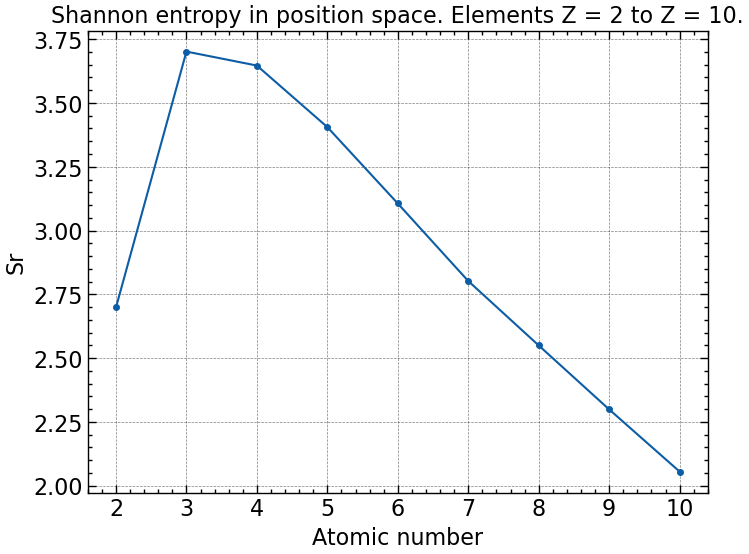

In [17]:
sr = []
for element in results:
    sr.append(results[element][0])
plt.plot(range(2, 11), sr, marker = '.', markersize = '8', linewidth = '1.5')
plt.title("Shannon entropy in position space. Elements Z = 2 to Z = 10.")
plt.ylabel("Sr")
plt.xlabel("Atomic number")
plt.savefig('sr.png')

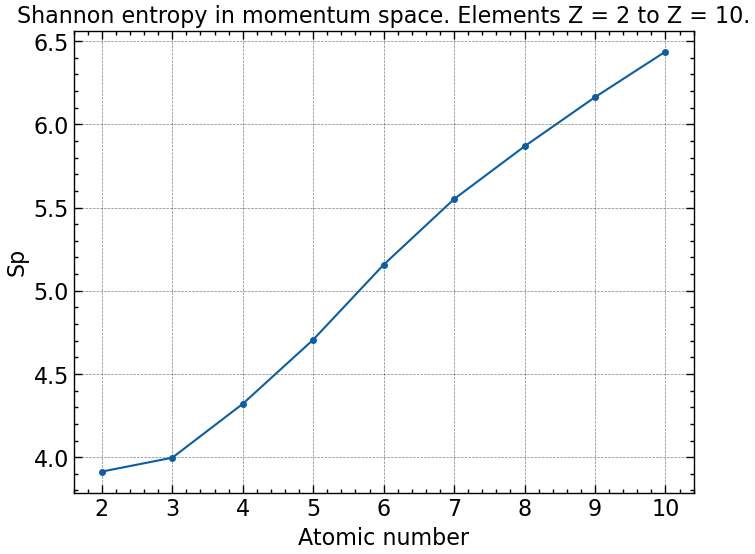

In [18]:
sk = []
for element in results:
    sk.append(results[element][1])
plt.plot(range(2, 11), sk, marker = '.', markersize = '8', linewidth = '1.5')
plt.title("Shannon entropy in momentum space. Elements Z = 2 to Z = 10.")
plt.ylabel("Sp")
plt.xlabel("Atomic number")
plt.savefig('sp.png')

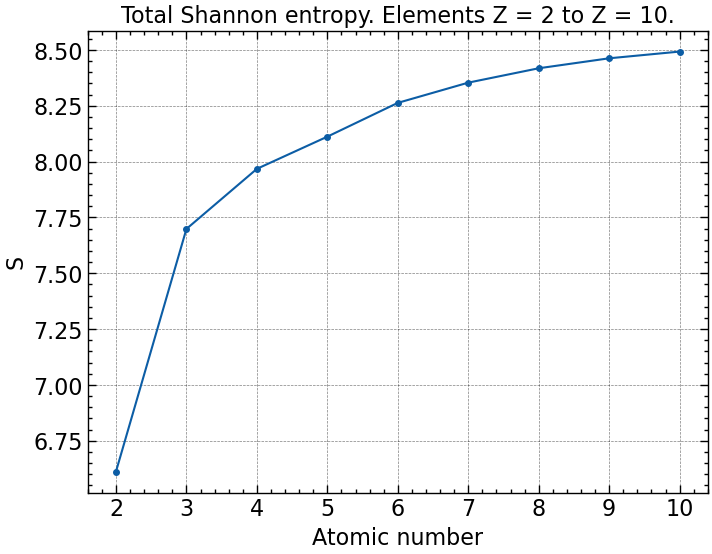

In [19]:
shannon = []
for element in results:
    shannon.append(results[element][2])
plt.plot(range(2, 11), shannon, marker = '.', markersize = '8', linewidth = '1.5')
plt.title("Total Shannon entropy. Elements Z = 2 to Z = 10.")
plt.ylabel("S")
plt.xlabel("Atomic number")
plt.savefig('s.png')

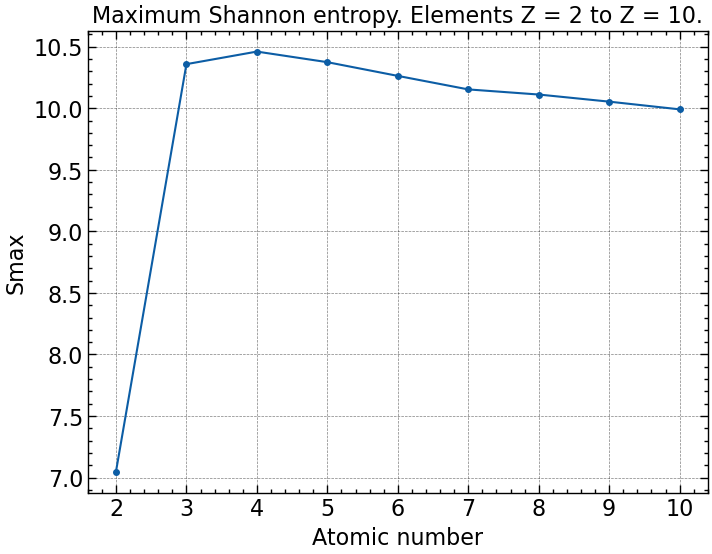

In [20]:
smax = []
for element in results:
    smax.append(results[element][3])
plt.plot(range(2, 11), smax, marker = '.', markersize = '8', linewidth = '1.5')
plt.title("Maximum Shannon entropy. Elements Z = 2 to Z = 10.")
plt.ylabel("Smax")
plt.xlabel("Atomic number")
plt.savefig('sm.png')

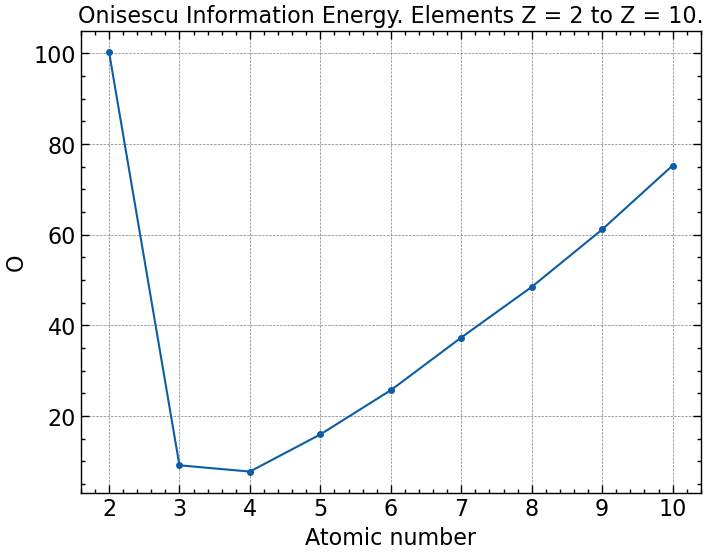

In [21]:
onisescu = []
for element in results:
    onisescu.append(results[element][5])
plt.plot(range(2, 11), onisescu, marker = '.', markersize = '8', linewidth = '1.5')
plt.title("Onisescu Information Energy. Elements Z = 2 to Z = 10.")
plt.ylabel("O")
plt.xlabel("Atomic number")
plt.savefig('o.png')

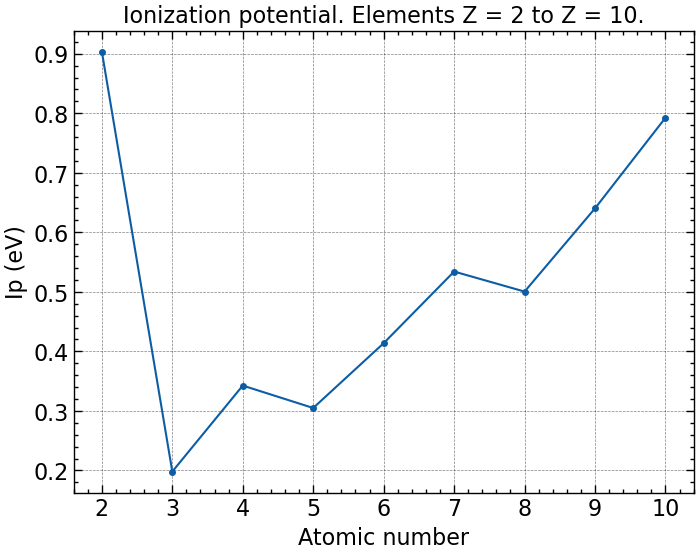

In [22]:
ion = []
for element in results:
    ion.append(results[element][10])
plt.plot(range(2, 11), ion, marker = '.', markersize = '8', linewidth = '1.5')
plt.title("Ionization potential. Elements Z = 2 to Z = 10.")
plt.ylabel("Ip (eV)")
plt.xlabel("Atomic number")
plt.savefig('ion.png')

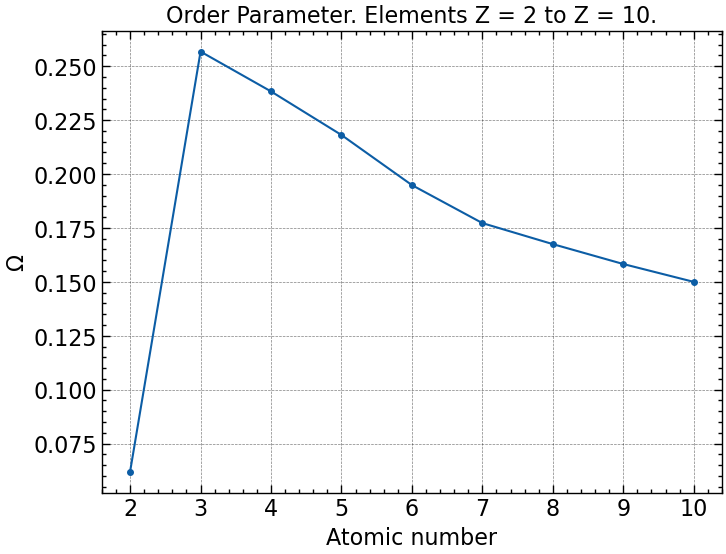

In [23]:
omega = []
for element in results:
    omega.append(results[element][4])
plt.plot(range(2, 11), omega, marker = '.', markersize = '8', linewidth = '1.5')
plt.title("Order Parameter. Elements Z = 2 to Z = 10.")
plt.ylabel("Ω")
plt.xlabel("Atomic number")
plt.savefig('w.png')

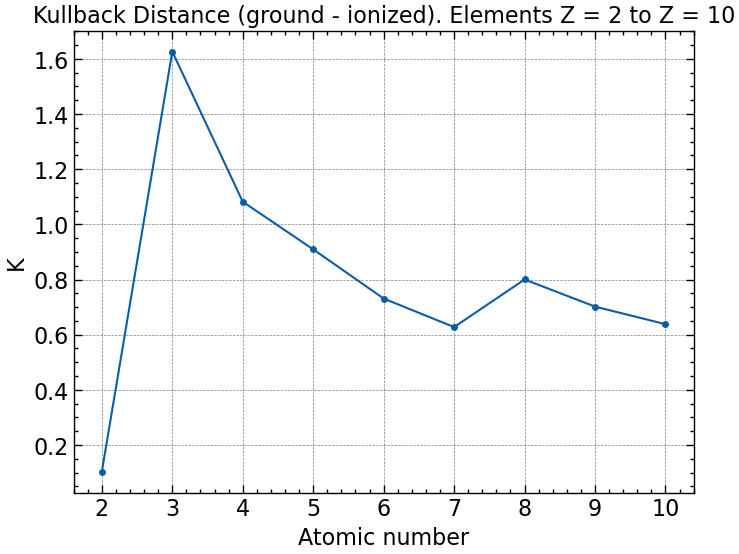

In [24]:
kul = []
for element in results:
    kul.append(results[element][6])
plt.plot(range(2, 11), kul, marker = '.', markersize = '8', linewidth = '1.5')
plt.title("Kullback Distance (ground - ionized). Elements Z = 2 to Z = 10")
plt.ylabel("K")
plt.xlabel("Atomic number")
plt.savefig('kl.png')

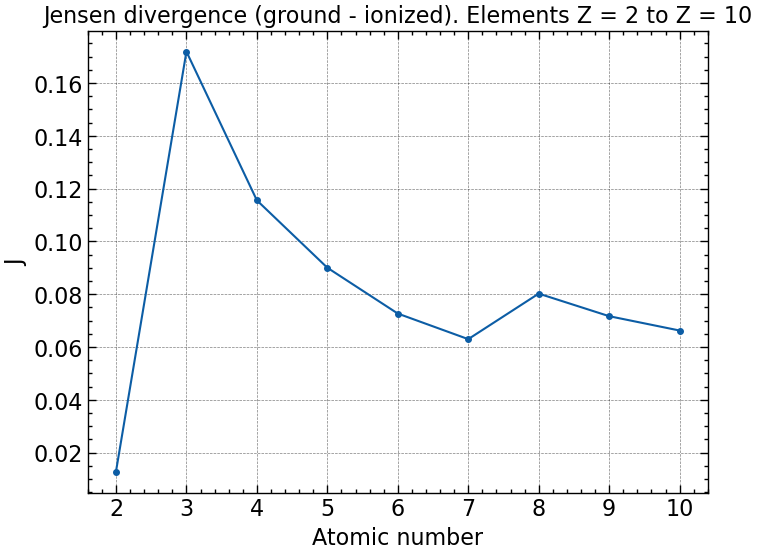

In [25]:
jensen = []
for element in results:
    jensen.append(results[element][7])
plt.plot(range(2, 11), jensen, marker = '.', markersize = '8', linewidth = '1.5')
plt.title("Jensen divergence (ground - ionized). Elements Z = 2 to Z = 10")
plt.ylabel("J")
plt.xlabel("Atomic number")
plt.savefig('j.png')

Text(0.5, 0, 'K')

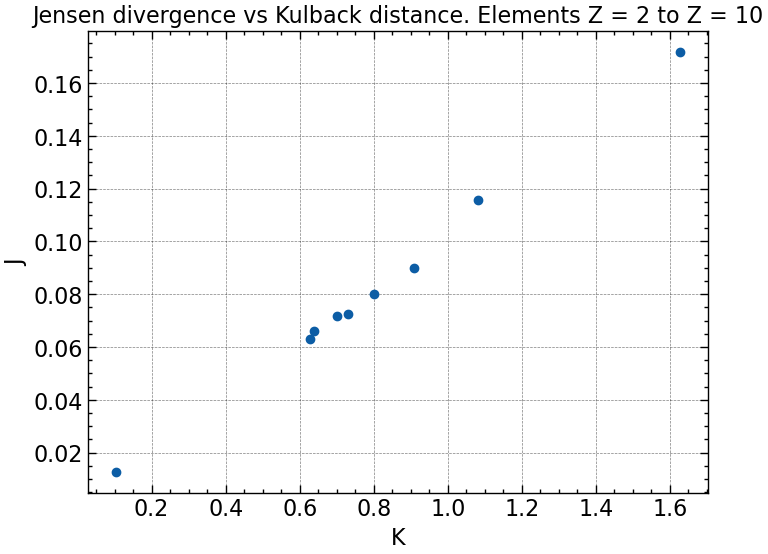

In [26]:
plt.scatter(kul, jensen)
plt.title("Jensen divergence vs Kulback distance. Elements Z = 2 to Z = 10")
plt.ylabel("J")
plt.xlabel("K")

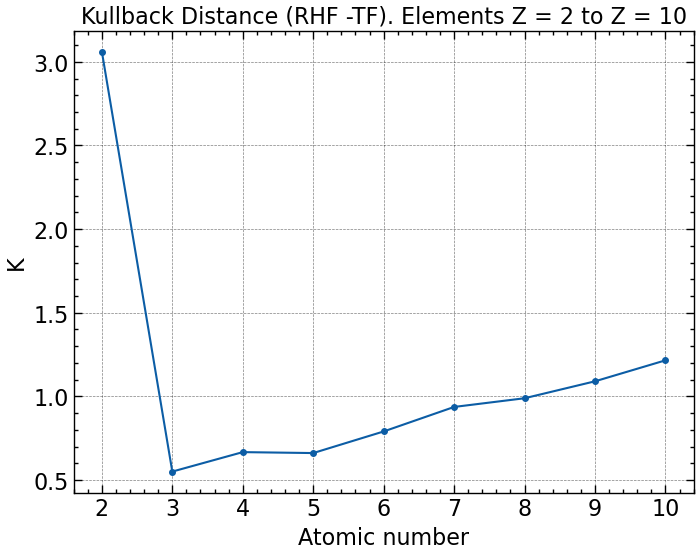

In [27]:
kul_tf = []
for element in results:
    kul_tf.append(results[element][8])
plt.plot(range(2, 11), kul_tf, marker = '.', markersize = '8', linewidth = '1.5')
plt.title("Kullback Distance (RHF -TF). Elements Z = 2 to Z = 10")
plt.ylabel("K")
plt.xlabel("Atomic number")
plt.savefig('kl2.png')

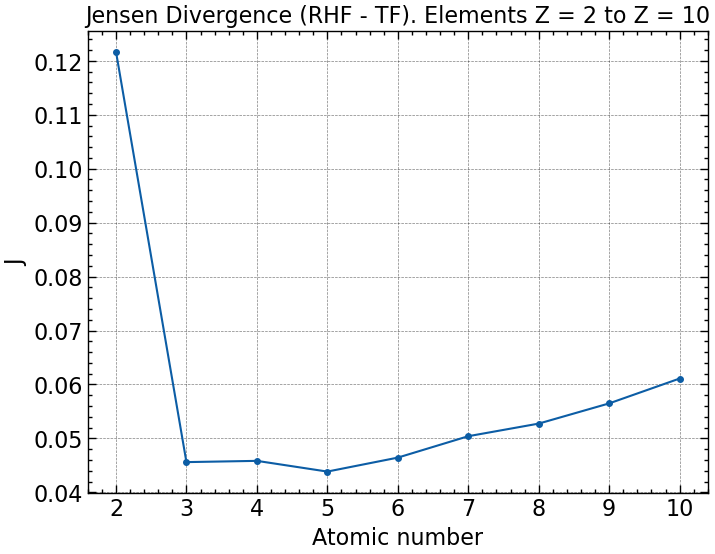

In [28]:
jen_tf = []
for element in results:
    jen_tf.append(results[element][9])
plt.plot(range(2, 11), jen_tf, marker = '.', markersize = '8', linewidth = '1.5')
plt.title("Jensen Divergence (RHF - TF). Elements Z = 2 to Z = 10")
plt.ylabel("J")
plt.xlabel("Atomic number")
plt.savefig('j2.png')

In [3]:
Sall = [
    6.56659, 6.61193, 7.69826, 7.81405, 8.11135, 8.26260, 8.35103, 8.41791,
    8.46215, 8.49221, 8.81319, 8.91038, 9.06497, 9.15294, 9.20767, 9.24871,
    9.27418, 9.28924, 9.47419, 9.54334, 9.60143, 9.64548, 9.68229, 9.70724,
    9.73945, 9.76478, 9.78613, 9.71120, 9.81401, 9.83493, 9.89832, 9.93896,
    9.96808, 9.99276, 10.01020, 10.02240, 10.12060, 10.16370, 10.20480, 10.23520,
    10.25720, 10.27350, 10.29840, 10.30610, 10.31840, 10.29390,
    10.33740, 10.35740, 10.40080, 10.43000, 10.45170, 10.47060,
    10.48490, 10.49600
]

In [4]:
Zs = range(1, 55)

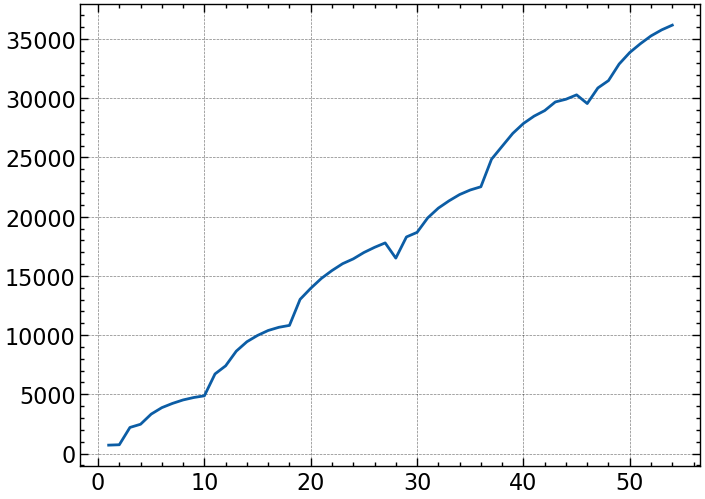

In [8]:
plt.plot(Zs, np.exp(Sall))

In [21]:
 coeff, cov = np.polyfit(np.log(Zs), Sall, deg = 1, cov = True)
a = coeff[0]
b = coeff[1]
ci_a = np.sqrt(cov[0][0])
ci_b = np.sqrt(cov[1][1])

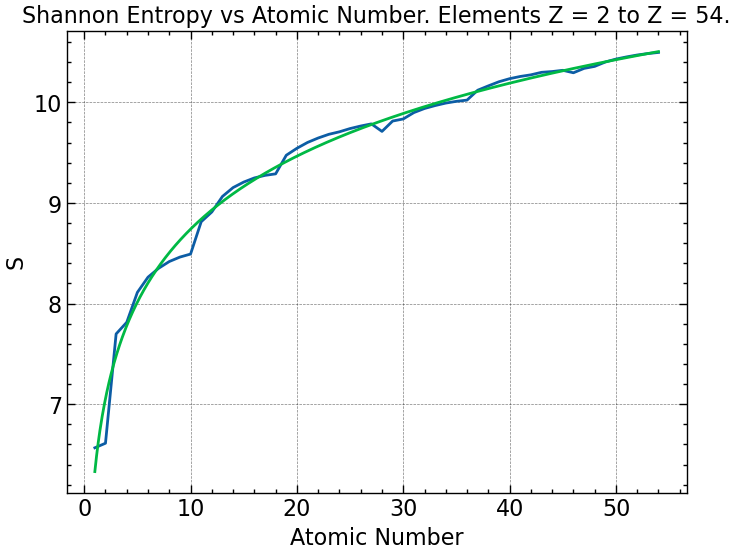

In [13]:
x = np.linspace(1, 54, 1000)
y = a*np.log(x) + b
plt.plot(Zs, Sall)
plt.ylabel('S')
plt.xlabel('Atomic Number')
plt.title('Shannon Entropy vs Atomic Number. Elements Z = 2 to Z = 54.')

plt.plot(x, y)
plt.savefig('s54.png')

In [23]:
print(f"a = {a} +- {ci_a}")

a = 1.046490646097358 +- 0.014976037420383656


In [24]:
print(f"b = {b} +- {ci_b}")

b = 6.330105362053678 +- 0.047463483710713815
